In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
data_dir = os.path.join(os.getcwd(), "..", "data")
daily_file = os.path.join(data_dir, "transit_daily.csv")

In [3]:
daily = pd.read_csv(daily_file, low_memory=False)

In [4]:
# gets a smaller version for faster troubleshooting
daily = daily.head(10000)
daily = daily.dropna(axis=0, subset=["service_date", "arrival_time"])
daily = daily.sort_values(["service_date", "arrival_time"])

In [5]:
import time


def to_timestamp(date_str, sec_num):
    gmtime = time.gmtime(sec_num)
    return pd.to_datetime(
        date_str
        + " "
        + str(gmtime.tm_hour)
        + ":"
        + str(gmtime.tm_min)
        + ":"
        + str(gmtime.tm_sec)
    )


daily["timestamp"] = np.vectorize(to_timestamp)(
    daily["service_date"], daily["arrival_time"]
)

daily.set_index("timestamp", inplace=True)

In [6]:
daily.deviance = daily.deviance.apply(lambda x: pd.to_timedelta(x).total_seconds())
# moves the labels one stop back, so that the previous stops information in the input for the current stops label
daily.deviance = daily.deviance.shift(
    -1
)  # not sure if the data is properly in order after looking at arrival_time
daily = daily.dropna(axis=0, subset=["deviance"])

In [7]:
int_types = [
    "arrival_time",
    "departure_time",
    "stop_time",
    "door",
    "gtfs_trip_id",
    "gtfs_stop_time_id",
    "stop_id",
]
daily[int_types] = daily[int_types].fillna(0).astype("int32")

In [8]:
daily["secs_stopped"] = daily.departure_time - daily.arrival_time

minutes_per_time_cat = 5
daily["time_cat"] = daily.arrival_time // 60 // minutes_per_time_cat

In [9]:
categories = [
    "trip_number",
    "gtfs_stop_time_id",
    "gtfs_stop_id",
    "gtfs_trip_id",
    "train",
    "trip_id",
    "data_agency",
    "data_source",
    "direction",
    "schedule_status",
    "service_key",
    "stop_id",
    "vehicle_number",
    "route_number",
    "trip_number",
    "time_cat",
    "door",
]

# should work from what I understand, but doesn't...
# daily[categories] = daily[categories].astype("category")


def make_categories(make_category, df):
    for category in make_category:
        df[category] = pd.Categorical(df[category])


make_categories(categories, daily)

In [10]:
daily.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
arrival_time,9882.0,4.994474e+04,16976.485882,16039.00,3.616350e+04,48448.000,6.172250e+04,93819.00
departure_time,9882.0,4.996182e+04,16976.331696,16039.00,3.619000e+04,48475.000,6.174050e+04,93819.00
lift,9882.0,7.387169e-03,0.093543,0.00,0.000000e+00,0.000,0.000000e+00,2.00
ons,9882.0,3.890913e-01,1.070482,0.00,0.000000e+00,0.000,0.000000e+00,20.00
offs,9882.0,3.761384e-01,1.076983,0.00,0.000000e+00,0.000,0.000000e+00,41.00
estimated_load,9882.0,6.693382e+00,6.495566,0.00,0.000000e+00,6.000,1.100000e+01,31.00
capacity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
early,9882.0,0.000000e+00,0.000000,0.00,0.000000e+00,0.000,0.000000e+00,0.00
on_time,9882.0,0.000000e+00,0.000000,0.00,0.000000e+00,0.000,0.000000e+00,0.00
late,9882.0,0.000000e+00,0.000000,0.00,0.000000e+00,0.000,0.000000e+00,0.00


In [11]:
empty_cols = [
    "early",
    "on_time",
    "late",
    "location_distance",
    "capacity",
]
daily = daily.drop(axis=1, columns=empty_cols)
# daily.describe().transpose()

In [12]:
print(daily[:50])

                         id service_date vehicle_number route_number  \
timestamp                                                              
2017-03-18 05:26:24  179158      3/18/17         2254.0          9.0   
2017-03-18 05:28:08  179157      3/18/17         2254.0          9.0   
2017-03-18 05:34:16  179156      3/18/17         2254.0          9.0   
2017-03-18 05:35:49  179155      3/18/17         2254.0          9.0   
2017-03-18 05:36:57  179154      3/18/17         2254.0          9.0   
2017-03-18 05:39:15  179153      3/18/17         2254.0          9.0   
2017-03-18 05:40:30  179152      3/18/17         2254.0          9.0   
2017-03-18 05:41:50  179151      3/18/17         2254.0          9.0   
2017-03-18 05:42:23  179150      3/18/17         2254.0          9.0   
2017-03-18 05:46:31  179149      3/18/17         2254.0          9.0   
2017-03-18 05:48:50  179148      3/18/17         2254.0          9.0   
2017-03-18 05:49:33  179147      3/18/17         2254.0         

In [13]:
used_cols = [
    "direction",
    "door",
    "lift",
    "dwell",
    "ons",
    "offs",
    "maximum_speed",
    "service_key",
    "schedule_status",
    "deviance",
    "secs_stopped",
    "time_cat",
    "stop_id",
]
x = daily[used_cols]
x = pd.get_dummies(x)  # turns all categoricals into one hot encoded columns!

target = x.pop("deviance")

In [14]:
print(list(x.columns))
print(target.name)

['lift', 'dwell', 'ons', 'offs', 'maximum_speed', 'secs_stopped', 'direction_0.0', 'direction_1.0', 'door_0', 'door_2', 'service_key_S', 'service_key_U', 'schedule_status_2.0', 'schedule_status_3.0', 'schedule_status_4.0', 'schedule_status_5.0', 'schedule_status_6.0', 'time_cat_53', 'time_cat_54', 'time_cat_55', 'time_cat_56', 'time_cat_57', 'time_cat_58', 'time_cat_59', 'time_cat_60', 'time_cat_61', 'time_cat_62', 'time_cat_63', 'time_cat_64', 'time_cat_65', 'time_cat_66', 'time_cat_67', 'time_cat_68', 'time_cat_69', 'time_cat_70', 'time_cat_71', 'time_cat_72', 'time_cat_73', 'time_cat_74', 'time_cat_75', 'time_cat_76', 'time_cat_77', 'time_cat_78', 'time_cat_79', 'time_cat_80', 'time_cat_81', 'time_cat_82', 'time_cat_83', 'time_cat_84', 'time_cat_85', 'time_cat_86', 'time_cat_87', 'time_cat_88', 'time_cat_89', 'time_cat_90', 'time_cat_91', 'time_cat_92', 'time_cat_93', 'time_cat_94', 'time_cat_95', 'time_cat_96', 'time_cat_97', 'time_cat_98', 'time_cat_99', 'time_cat_100', 'time_cat_

In [15]:
import tensorflow as tf

# https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

batch_size = 15
data_len = len(x)
train_test_ratio = 0.7

train_test_split = int(train_test_ratio * data_len)
dataset = tf.data.Dataset.from_tensor_slices((x.values, target.values))
dataset = dataset.shuffle(data_len)
train_dataset = dataset.take(train_test_split).batch(batch_size)
test_dataset = dataset.skip(train_test_split).batch(batch_size)

In [16]:
# for features, target in train_dataset.take(5):
#     print("Features: {}, Target: {}".format(features, target))

In [17]:
def get_compiled_model():
    model = tf.keras.Sequential(
        [
            # won't work because we can't normalize the output?
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1),
        ]
    )

    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.MeanSquaredError(
            reduction="auto", name="mean_squared_error"
        ),
        metrics=["accuracy", "mean_absolute_error"],
    )

    return model

In [18]:
model = get_compiled_model()
model.fit(train_dataset, epochs=3)

Epoch 1/3
462/462 [==============================] - 8s 17ms/step - loss: 29982.1074 - accuracy: 0.0056 - mean_absolute_error: 100.4859
Epoch 2/3
462/462 [==============================] - 8s 16ms/step - loss: 24886.1738 - accuracy: 0.0053 - mean_absolute_error: 97.0158
Epoch 3/3
462/462 [==============================] - 8s 16ms/step - loss: 26050.1582 - accuracy: 0.0061 - mean_absolute_error: 97.0796


In [19]:
model.evaluate(test_dataset)

198/198 [==============================] - 1s 6ms/step - loss: 39372.1602 - accuracy: 0.0051 - mean_absolute_error: 135.2485


[39372.16015625, 0.00505902199074626, 135.2484893798828]

In [20]:
preds = []
labels = []
for data in test_dataset:
    preds.append(model.predict_on_batch(data[0]).flatten())
    labels.append(data[1])

preds = [p.tolist() for p in preds]
labels = [l.numpy().tolist() for l in labels]

# https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
def flatten(t):
    return [item for sublist in t for item in sublist]


preds = flatten(preds)
labels = flatten(labels)
assert len(preds) == len(labels)

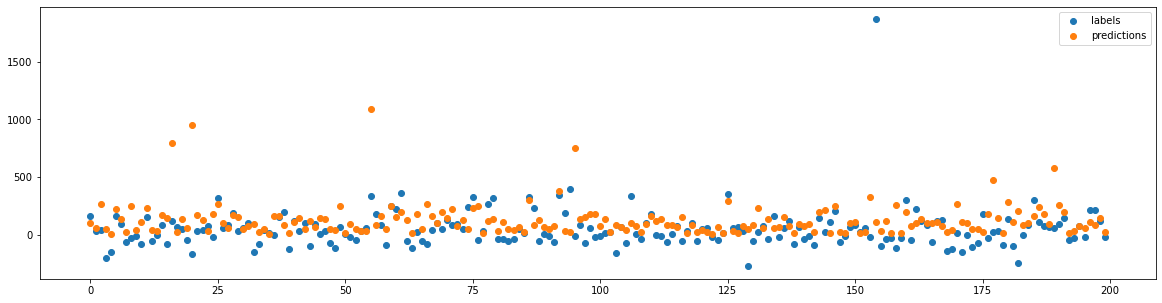

In [22]:
from matplotlib import pyplot as plt

# adjust these numbers to change the width and height of the plot!
plt.rcParams["figure.figsize"] = [20, 5]


def plot(r, l, preds, labels):
    assert len(preds) == len(labels)
    preds = preds[r:l]
    labels = labels[r:l]
    x = list(range(len(preds)))
    plt.scatter(x, labels, label="labels")
    plt.scatter(x, preds, label="predictions")
    plt.legend()
    plt.show()


plot(0, 200, preds, labels)